# Classification Part

## Goal
Using the meta data of movies to build a classifier that can predict the average vote given a movie.

## Methods

Specifically, the meta data we have are:
1. adult
2. belongs_to_collection
3. budget
4. genres
5. homepage
6. id
7. imdb_id
8. original_language
9. original_title
10. overview
11. popularity
12. poster_path
13. production_companies
14. production_countries
15. release_date
16. revenue
17. runtime
18. spoken_languages
19. status
20. tagline
21. title
22. video
23. vote_average
24. vote_count

We will use *budget, genres, popularity, production_compnanies, production_countries, revenue, runtime* as features.

We will use *vote_average* as groundtruth value.

Since the features here are all of different types and not all of them are numeric, it's a good choice to use **decision trees**. Another good property about decision trees are that they provide interpretability, which is quite important in order to achieve our aim.

## How does it contribute to our aim?
As our aim claims, we want to discover some interesting information from this move dataset. And for movies, we'd like to know what determines the average vote of a given movie. By building a decision tree classifier and visualize it, we are able to see how the decision process is carried out and what features contribute most to the average vote of the movie. That, we think, meets our aim.

In [22]:
import os
import re
import shap
import sklearn
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [23]:
# Some environment variables
os.environ['OMP_NUM_THREADS']='1'

## 1. Load the data

In [24]:
movies_metadata = pd.read_csv('/mnt/data3/duyx/data/dm/movies_metadata.csv')

numeric_features_name = ['budget', 'popularity', 'revenue', 'runtime']
non_numeric_features_name = ['genres', 'production_companies', 'production_countries']
truth_value_name = ['vote_average', 'vote_count']

# Extract features that we are going to use
movies_metadata = movies_metadata[numeric_features_name + non_numeric_features_name + truth_value_name]

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


In [25]:
print('Raw dataset length: %d' % (len(movies_metadata)))

Raw dataset length: 45466


## Preprocessing the data

After the preprocessing, numeric features should results in float or NaN. Multi-hot features should results in list or NaN.

In [26]:
if (movies_metadata['production_companies'].isna()).any():
    print('NaN in production_companies')
if (movies_metadata['genres'].isna()).any():
    print('NaN in genres')
if (movies_metadata['production_countries'].isna()).any():
    print('NaN in production_countries')
    
    
pd.isna(movies_metadata['production_countries'][19729])

NaN in production_companies
NaN in production_countries


True

### Principles
We use NaN to represents missing values

In [27]:
movies_metadata['production_companies']

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45466, dtype: object

In [28]:
def extract_ids(regex_infos, regex_ids, features_list):
    '''
    For genres, production_companies, the value we have are all in the form of
    [{'id': 1, 'name': XXX}]
    This function is used to deal with these kinds of information
    '''
    ids_lists = [] # List of list of ids for each movie
    for features_str in features_list:
        # features_str is the content of each row in the dataset
        # Two cases are considered as missing
        # 1. NaN
        # 2. An empty list []
        ids = []
        if not pd.isna(features_str):
            features = re.findall(regex_infos, features_str)
            for feature in features:
                id_dict = re.search(regex_ids, feature).group()
                id = int(id_dict.split(':')[1].strip())
                ids.append(id)
        
        if len(ids) == 0:
            ids_lists.append(np.nan)
        else:
            ids_lists.append(ids)

    return ids_lists

In [29]:
def extract_names(regex_infos, regex_names, features_list):
    '''
    For genres, production_companies, the value we have are all in the form of
    [{'id': 1, 'name': XXX}]
    This function is used to deal with these kinds of information
    '''
    names_lists = [] # List of list of ids for each movie
    for features_str in features_list:
        # features_str is the content of each row in the dataset
        # Two cases are considered as missing
        # 1. NaN
        # 2. An empty list []
        names = []
        if not pd.isna(features_str):
            features = re.findall(regex_infos, features_str)
            for feature in features:
                name_dict = re.search(regex_names, feature).group()
                name = name_dict.split(':')[1].strip()[1:-1]
                names.append(name)
        
        if len(names) == 0:
            names_lists.append(np.nan)
        else:
            names_lists.append(names)

    return names_lists

In [30]:
def names_to_ids(names_list):
    # Convert a list of names to ids
    names_set = set()
    ids_list = []
    for names in names_list:
        if isinstance(names, list):
            for name in names:
                names_set.add(name)
                
    names_unique_list = list(names_set)
    print('Total number of ids: %d' % (len(names_unique_list)))
    for names in names_list:
        if isinstance(names, list):
            ids = []
            for name in names:
                ids.append(names_unique_list.index(name))
            
            ids_list.append(ids)
        else:
            # Missing values
            ids_list.append(np.nan)
    
    return ids_list

### 1. Convert data types of 'budget', 'popularity', 'revenue', 'runtime' and 'vote_average' to numeric values and handle missing values

In [31]:
# There are columns that is number but has type other than numeric, we need to convert them into numeric values first
# In our case, it's budget and popularity
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['popularity'] = pd.to_numeric(movies_metadata['popularity'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')
movies_metadata['runtime'] = pd.to_numeric(movies_metadata['runtime'], errors='coerce')

# For budget and revenue, the values should be greater than 0, otherwise, we should also consider it as a missing value. Therefore, we need to convert all 0 values to NaN
movies_metadata['budget'].replace(0, np.nan, inplace=True)
movies_metadata['revenue'].replace(0, np.nan, inplace=True)

### 2. Remove those with vote_count less than 5 or vote_count is NaN

In [32]:
movies_metadata['vote_count'] = pd.to_numeric(movies_metadata['vote_count'], errors='coerce')
movies_metadata.drop(movies_metadata[movies_metadata['vote_count'] < 5].index, inplace=True)
movies_metadata.drop(movies_metadata[movies_metadata['vote_count'].isna()].index, inplace=True)

In [33]:
print('Removing all examples that have vote count less than 5 or vote count is NaN...')
print('Remaining dataset length: %d' % (len(movies_metadata)))

Removing all examples that have vote count less than 5 or vote count is NaN...
Remaining dataset length: 30898


### 3. Deal with the genres

In [34]:
genres = movies_metadata['genres']

In [35]:
regex_infos = "\{[^\{\}]+\}"
regex_names = "'name': '[a-zA-Z ]+'"
genres_names_list = extract_names(regex_infos, regex_names, genres)
#genres_ids_list = names_to_ids(genres_names_list)
genres_ids_list = genres_names_list

### 4. Deal with production companies

In [36]:
regex_infos = "\{[^\{\}]+\}"
regex_names = "'name': (('[^']+')|(\"[^\"]+\"))"
production_companies_names_list = extract_names(regex_infos, regex_names, movies_metadata['production_companies'])
#production_companies_ids_list = names_to_ids(production_companies_names_list)
production_companies_ids_list = production_companies_names_list

### 5. Deal with production_countries 

In [37]:
regex_infos = "\{[^\{\}]+\}"
regex_names = "'iso_3166_1': '[A-Z]+'"
production_countries_names_list = extract_names(regex_infos, regex_names, movies_metadata['production_countries'])
#production_countries_ids_list = names_to_ids(production_countries_names_list)
production_countries_ids_list = production_countries_names_list

### 6. Convert 'genres', 'production_companies' and 'production_countries' to multi-hot features

In [38]:
mlb = MultiLabelBinarizer()

In [39]:
def to_multi_hot(mlb, ids_series):
#     nan_mask = ids_series.isna()
#     multi_hot_labels = pd.Series(mlb.fit_transform(ids_series[~nan_mask]).tolist())
#     j = 0
#     for i in ids_series.index:
#         if not nan_mask[i]:
#             ids_series[i] = multi_hot_labels[j]
#             j += 1

    return ids_series

In [40]:
genres_series = to_multi_hot(mlb, pd.Series(genres_ids_list))
production_companies_series = to_multi_hot(mlb, pd.Series(production_companies_ids_list))
production_countries_series = to_multi_hot(mlb, pd.Series(production_countries_ids_list))

### Finally, put them together to obatin the final dataset

In [41]:
budget = pd.DataFrame(movies_metadata['budget'])
popularity = pd.DataFrame(movies_metadata['popularity'])
revenue = pd.DataFrame(movies_metadata['revenue'])
runtime = pd.DataFrame(movies_metadata['runtime'])
genres = pd.DataFrame(genres_series, columns=['genres'])
production_companies = pd.DataFrame(production_companies_series, columns=['production_companies'])
production_countries = pd.DataFrame(production_countries_series, columns=['production_countries'])

X_df = pd.concat([
    budget.reset_index(drop=True),
    popularity.reset_index(drop=True),
    revenue.reset_index(drop=True),
    runtime.reset_index(drop=True),
    genres,
    production_companies,
    production_countries,
], axis=1)

In [43]:
X_df.columns = ['Budget', 'Popularity', 'Revenue', 'Runtime', 'genres', 'production_companies', 'production_countries']

In [44]:
X_df

,Budget,Popularity,Revenue,Runtime,genres,production_companies,production_countries
0,30000000.0,21.946943,373554033.0,81.0,"[Animation, Comedy, Family]",[Pixar Animation Studios],[US]
1,65000000.0,17.015539,262797249.0,104.0,"[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[US]
2,NaN,11.712900,NaN,101.0,"[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[US]
3,16000000.0,3.859495,81452156.0,127.0,"[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[US]
4,NaN,8.387519,76578911.0,106.0,[Comedy],"[Sandollar Productions, Touchstone Pictures]",[US]
...,...,...,...,...,...,...,...
30893,NaN,0.225432,NaN,2.0,"[Comedy, Fantasy]",[Star-Film],[FR]
30894,NaN,1.559596,NaN,146.0,"[Crime, Drama, Thriller]","[Mad Films, Third Eye Pictures]",[IN]
30895,NaN,0.222814,NaN,65.0,"[Horror, Mystery, Thriller]",[Universal Pictures],[US]
30896,NaN,5.683753,NaN,104.0,"[Drama, Action, Romance]","[Westdeutscher Rundfunk (WDR), Working Title F...","[CA, DE, GB, US]"


In [48]:
X_df.to_csv('processed_meta_data.csv', index=False)

In [45]:
X_df.dtypes

Budget                  float64
Popularity              float64
Revenue                 float64
Runtime                 float64
genres                   object
production_companies     object
production_countries     object
dtype: object

In [46]:
Y_df = pd.DataFrame(movies_metadata['vote_average']).reset_index(drop=True)

In [47]:
Y_df

,vote_average
0,7.7
1,6.9
2,6.5
3,6.1
4,5.7
...,...
30893,6.5
30894,6.6
30895,6.3
30896,5.7


## Perform classification

### Using numeric features

In [52]:
test_size = len(X_df) // 10
train_size = len(X_df) - test_size
X_df_train = X_df[:train_size]
Y_df_train = Y_df[:train_size]
X_df_test = X_df[train_size:]
Y_df_test = Y_df[train_size:]

In [53]:
train = xgb.DMatrix(X_df_train[numeric_features_name], label=Y_df_train, missing=np.nan)
test = xgb.DMatrix(X_df_test[numeric_features_name], label=Y_df_test, missing=np.nan)

In [54]:
xgb_params = {
    'eta': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'max_depth': 5
}

In [55]:
eval_list = [(test, 'eval'), (train, 'train')]

In [56]:
model=xgb.train(xgb_params, train, 200, eval_list)

[0]	eval-rmse:5.60179	train-rmse:5.64170
[1]	eval-rmse:5.54766	train-rmse:5.58709
[2]	eval-rmse:5.49425	train-rmse:5.53300
[3]	eval-rmse:5.44132	train-rmse:5.47951
[4]	eval-rmse:5.38891	train-rmse:5.42652
[5]	eval-rmse:5.33698	train-rmse:5.37407
[6]	eval-rmse:5.28576	train-rmse:5.32223
[7]	eval-rmse:5.23502	train-rmse:5.27094
[8]	eval-rmse:5.18483	train-rmse:5.22018
[9]	eval-rmse:5.13510	train-rmse:5.16992
[10]	eval-rmse:5.08589	train-rmse:5.12011
[11]	eval-rmse:5.03716	train-rmse:5.07084
[12]	eval-rmse:4.98928	train-rmse:5.02220
[13]	eval-rmse:4.94166	train-rmse:4.97401
[14]	eval-rmse:4.89470	train-rmse:4.92633
[15]	eval-rmse:4.84815	train-rmse:4.87914
[16]	eval-rmse:4.80206	train-rmse:4.83244
[17]	eval-rmse:4.75638	train-rmse:4.78620
[18]	eval-rmse:4.71115	train-rmse:4.74041
[19]	eval-rmse:4.66645	train-rmse:4.69510
[20]	eval-rmse:4.62260	train-rmse:4.65043
[21]	eval-rmse:4.57887	train-rmse:4.60604
[22]	eval-rmse:4.53563	train-rmse:4.56211
[23]	eval-rmse:4.49278	train-rmse:4.51868
[2

[194]	eval-rmse:1.38326	train-rmse:1.25333
[195]	eval-rmse:1.37908	train-rmse:1.24829
[196]	eval-rmse:1.37487	train-rmse:1.24328
[197]	eval-rmse:1.37083	train-rmse:1.23840
[198]	eval-rmse:1.36677	train-rmse:1.23360
[199]	eval-rmse:1.36288	train-rmse:1.22881


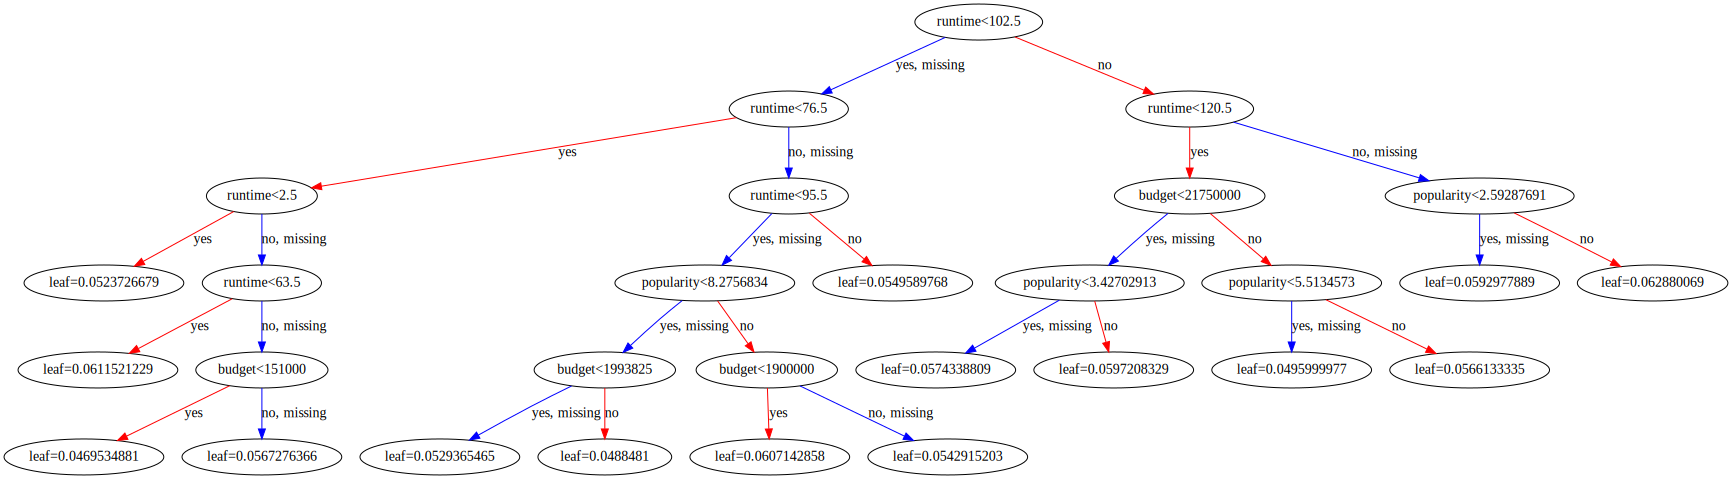

In [57]:
xgb.to_graphviz(model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

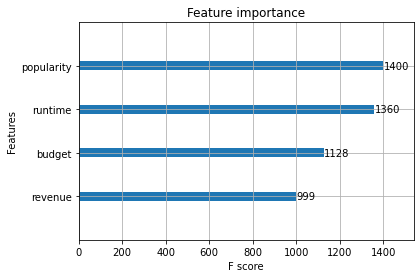

In [58]:
xgb.plot_importance(model, importance_type='weight')

### Use numeirc + categorical features

Production companies and production countries are not suitable, since they have so many categories. We will only use genres.

In [50]:
# When using categorical features, we drop all those with missing values in genres
numeric_features_name = ['Runtime', 'Budget', 'Revenue', 'Popularity']
X_df_num_genres = X_df[numeric_features_name + ['genres']]
nan_mask = X_df_num_genres['genres'].isna()
X_df_num_genres = X_df_num_genres[~nan_mask]
Y_df_num_genres = Y_df[~nan_mask]
assert not (X_df_num_genres['genres'].isna()).all()

In [51]:
# Convert multi category features to dummies
genres_dummies = X_df_num_genres['genres'].str.join(sep='*').str.get_dummies(sep='*')

In [52]:
X_df_num_genres = pd.concat([X_df_num_genres[numeric_features_name], genres_dummies], axis=1)

In [53]:
test_size = len(X_df_num_genres) // 10
train_size = len(X_df_num_genres) - test_size
X_df_train = X_df_num_genres[:train_size]
Y_df_train = Y_df_num_genres[:train_size]
X_df_test = X_df_num_genres[train_size:]
Y_df_test = Y_df_num_genres[train_size:]

In [54]:
train = xgb.DMatrix(X_df_train, label=Y_df_train, missing=np.nan)
test = xgb.DMatrix(X_df_test, label=Y_df_test, missing=np.nan)

### Hyper parameter tunning

In [55]:
default_param = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

1. Tunning the number of boost round

In [49]:
model = XGBRegressor(**default_param)
cvresult = xgb.cv(model.get_xgb_params(), train, num_boost_round=1000, nfold=5, early_stopping_rounds=50)

In [52]:
print('Optimal rounds: %d' % (cvresult.shape[0]))

Optimal rounds: 125


2. Tunning the max_depth and min_child_weight

In [64]:
default_param['n_estimators'] = 150
param_test = {
    'max_depth': range(3, 10, 1),
    'min_child_weight': range(1, 6, 1),
}

grid_search = GridSearchCV(estimator=XGBRegressor(nthread=2, **default_param), param_grid=param_test, scoring='neg_mean_squared_error', cv=5, verbose=2)
grid_search.fit(X_df_train, Y_df_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=3, min_child_weight=1, total=   1.3s
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .................. max_depth=3, min_child_weight=1, total=   1.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   1.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   1.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=   1.4s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total=   1.4s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total=   1.4s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .................. max_depth=3, min_child_weight=2, total=   1.4s
[CV] max_depth=3, min_child_weight=2 .................................
[CV] .

[CV] .................. max_depth=5, min_child_weight=2, total=   2.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   2.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   2.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   2.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   2.2s
[CV] max_depth=5, min_child_weight=3 .................................
[CV] .................. max_depth=5, min_child_weight=3, total=   2.2s
[CV] max_depth=5, min_child_weight=4 .................................
[CV] .................. max_depth=5, min_child_weight=4, total=   2.1s
[CV] max_depth=5, min_child_weight=4 .................................
[CV] .

[CV] .................. max_depth=7, min_child_weight=4, total=   3.1s
[CV] max_depth=7, min_child_weight=4 .................................
[CV] .................. max_depth=7, min_child_weight=4, total=   3.1s
[CV] max_depth=7, min_child_weight=4 .................................
[CV] .................. max_depth=7, min_child_weight=4, total=   3.1s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] .................. max_depth=7, min_child_weight=5, total=   3.0s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] .................. max_depth=7, min_child_weight=5, total=   3.0s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] .................. max_depth=7, min_child_weight=5, total=   3.0s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] .................. max_depth=7, min_child_weight=5, total=   3.1s
[CV] max_depth=7, min_child_weight=5 .................................
[CV] .

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  7.8min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=150, n_jobs=None, nthread=2,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_param

In [70]:
print('Best score: %f' % grid_search.best_score_)
print('Best param: ', grid_search.best_params_)

Best score: -0.794177
Best param:  {'max_depth': 5, 'min_child_weight': 4}


3. Tunning the gamma

In [71]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)]
}
default_param['max_depth'] = 5
default_param['min_child_weight'] = 4

grid_search = GridSearchCV(estimator=XGBRegressor(nthread=2, **default_param), param_grid=param_test, scoring='neg_mean_squared_error', cv=5, verbose=2)
grid_search.fit(X_df_train, Y_df_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................ gamma=0.0, total=   2.2s
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] ........................................ gamma=0.0, total=   2.2s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.2s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.2s
[CV] gamma=0.0 .......................................................
[CV] ........................................ gamma=0.0, total=   2.2s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   2.1s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   2.2s
[CV] gamma=0.1 .......................................................
[CV] ........................................ gamma=0.1, total=   2.2s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   54.4s finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=4,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=150, n_jobs=None, nthread=2,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_param

In [72]:
print('Best score: %f' % grid_search.best_score_)
print('Best param: ', grid_search.best_params_)

Best score: -0.794111
Best param:  {'gamma': 0.1}


4. Tunning the subsample and colsample_bytree

In [73]:
param_test = {
    'subsample': [i / 10.0 for i in range(6, 10)],
    'colsample_bytree': [i / 10.0 for i in range(6, 10)],
}
default_param['gamma'] = 0.1

grid_search = GridSearchCV(estimator=XGBRegressor(nthread=2, **default_param), param_grid=param_test, scoring='neg_mean_squared_error', cv=5, verbose=2)
grid_search.fit(X_df_train, Y_df_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.6, total=   1.9s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.7, total=   1.8s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.7, total=   1.8s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.6, subsample=0.7, total=   1.8s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .

[CV] .............. colsample_bytree=0.8, subsample=0.9, total=   2.2s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.6, total=   2.5s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.6, total=   2.5s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.6, total=   2.5s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.6, total=   2.5s
[CV] colsample_bytree=0.9, subsample=0.6 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.6, total=   2.5s
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV] .............. colsample_bytree=0.9, subsample=0.7, total=   2.4s
[CV] colsample_bytree=0.9, subsample=0.7 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.8min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0.1, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=4,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=150, n_jobs=None, nthread=2,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_par

In [74]:
print('Best score: %f' % grid_search.best_score_)
print('Best param: ', grid_search.best_params_)

Best score: -0.793141
Best param:  {'colsample_bytree': 0.6, 'subsample': 0.8}


5. Tunning the reg_alpha

In [78]:
param_test = {
    'reg_alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}
default_param['subsample'] = 0.8
default_param['colsample_bytree'] = 0.6

grid_search = GridSearchCV(estimator=XGBRegressor(nthread=2, **default_param), param_grid=param_test, scoring='neg_mean_squared_error', cv=5, verbose=2)
grid_search.fit(X_df_train, Y_df_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] reg_alpha=1e-05 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................. reg_alpha=1e-05, total=   1.8s
[CV] reg_alpha=1e-05 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .................................. reg_alpha=1e-05, total=   1.8s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   1.8s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   1.8s
[CV] reg_alpha=1e-05 .................................................
[CV] .................................. reg_alpha=1e-05, total=   1.8s
[CV] reg_alpha=0.0001 ................................................
[CV] ................................. reg_alpha=0.0001, total=   1.7s
[CV] reg_alpha=0.0001 ................................................
[CV] ................................. reg_alpha=0.0001, total=   1.8s
[CV] reg_alpha=0.0001 ................................................
[CV] ................................. reg_alpha=0.0001, total=   1.9s
[CV] reg_alpha=0.0001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.6,
                                    gamma=0.1, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=4,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=150, n_jobs=None, nthread=2,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=0.8,
                                    tree_method=None, validate_par

In [79]:
print('Best score: %f' % grid_search.best_score_)
print('Best param: ', grid_search.best_params_)

Best score: -0.792969
Best param:  {'reg_alpha': 10}


In [57]:
default_param['reg_alpha'] = 10
eval_list = [(test, 'eval')]
model=xgb.train(default_param, train, default_param['n_estimators'], eval_list)

[16:44:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-rmse:5.10329
[1]	eval-rmse:4.61510
[2]	eval-rmse:4.17702
[3]	eval-rmse:3.78530
[4]	eval-rmse:3.43876
[5]	eval-rmse:3.12766
[6]	eval-rmse:2.85575
[7]	eval-rmse:2.61145
[8]	eval-rmse:2.39784
[9]	eval-rmse:2.20676
[10]	eval-rmse:2.04234
[11]	eval-rmse:1.89658
[12]	eval-rmse:1.76987
[13]	eval-rmse:1.65979
[14]	eval-rmse:1.56482
[15]	eval-rmse:1.48321
[16]	eval-rmse:1.41378
[17]	eval-rmse:1.35530
[18]	eval-rmse:1.30601
[19]	eval-rmse:1.26525
[20]	eval-rmse:1.22919
[21]	eval-rmse:1.20112
[22]	eval-rmse:1.17637
[23]	eval-rmse:1.15650
[24]	eval-rmse:1.14022
[25]	eval-rmse:1.12588
[26]	eval-rms

In [58]:
image = xgb.to_graphviz(model)
image.render('single_tree', format='pdf')

'single_tree.pdf'

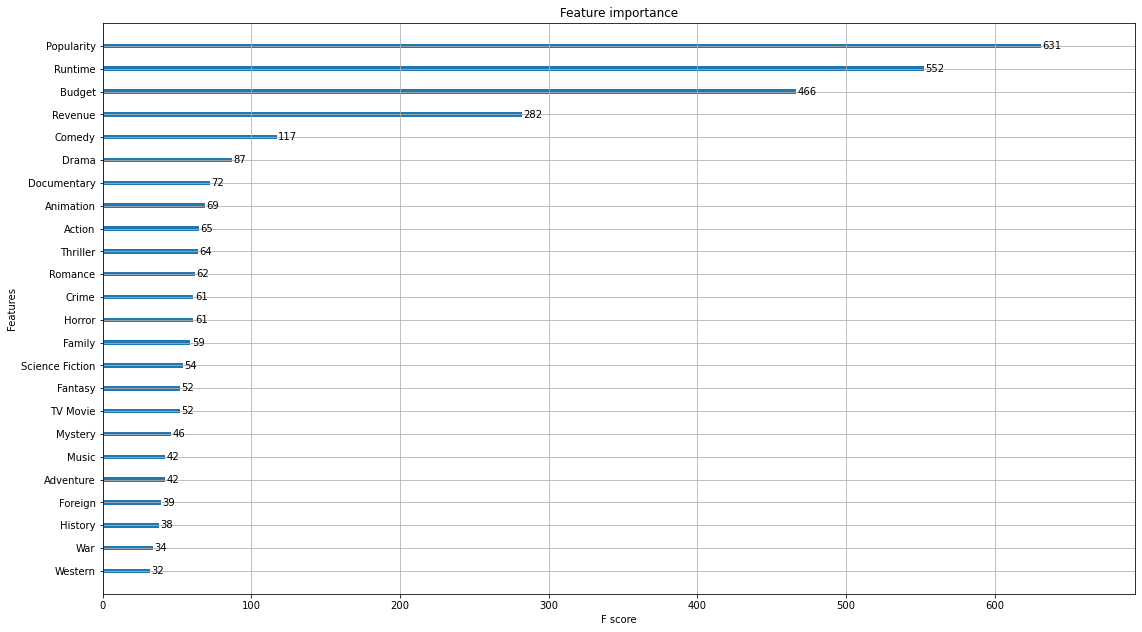

In [59]:
xgb.plot_importance(model)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('weight.pdf', bbox_inches='tight')

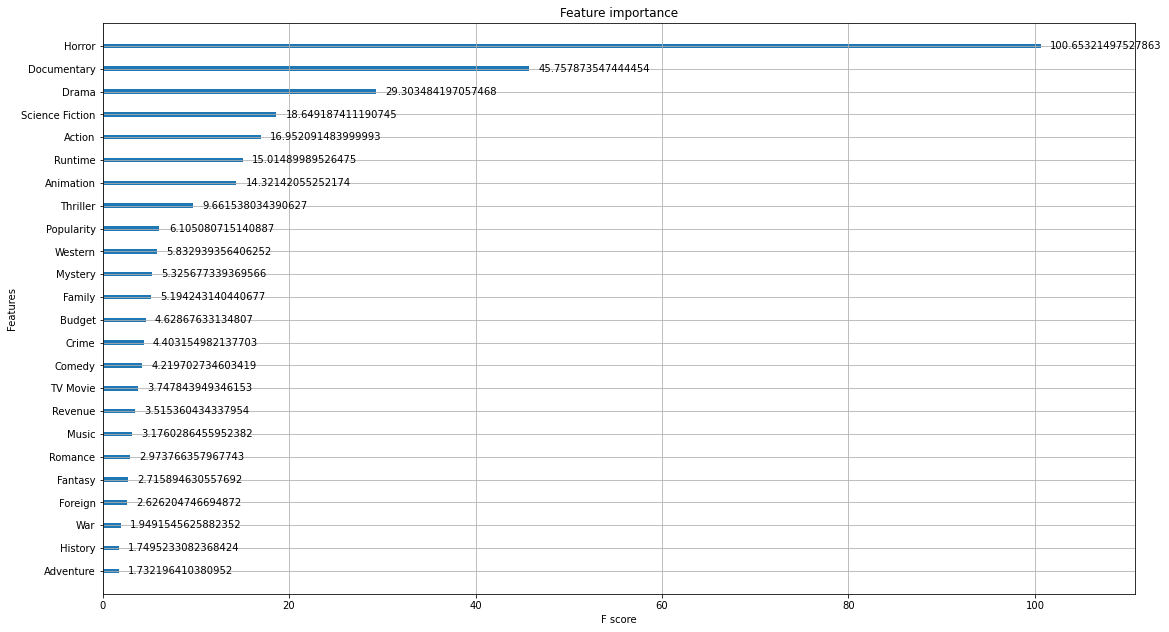

In [60]:
xgb.plot_importance(model, importance_type='gain')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('gain.pdf', bbox_inches='tight')

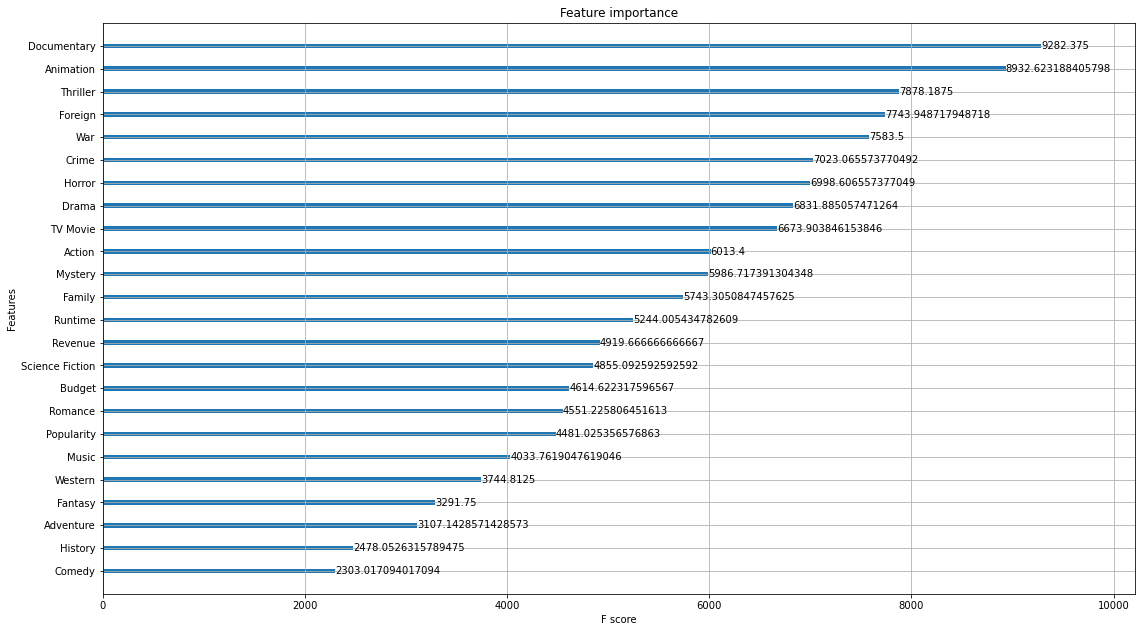

In [61]:
xgb.plot_importance(model, importance_type='cover')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig('cover.pdf', bbox_inches='tight')

### Explain the model using SHAP

In [62]:
explainer = shap.TreeExplainer(model)
shape_values = explainer.shap_values(X_df_train)

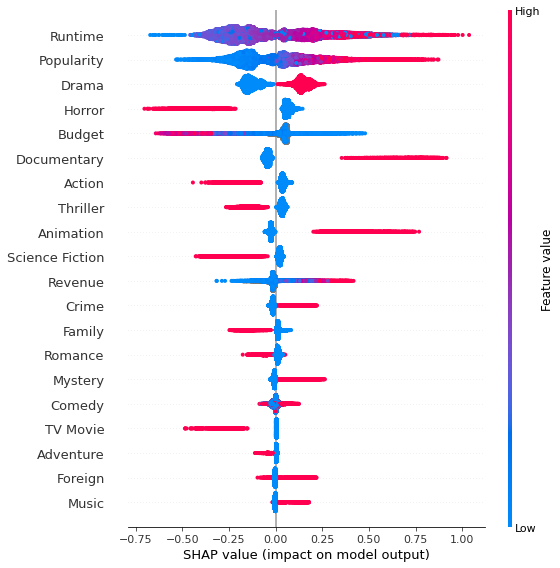

In [63]:
shap.summary_plot(shape_values, X_df_train, show=False)
fig = plt.gcf()
#fig.set_size_inches(20, 10)
plt.savefig('imp_bar1.pdf', bbox_inches='tight')

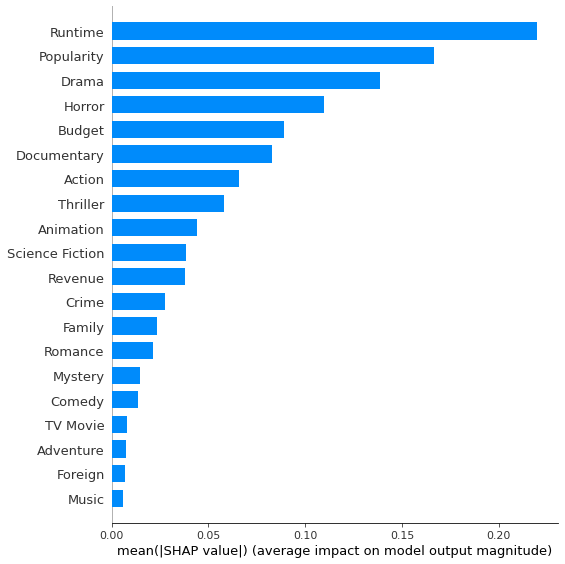

In [64]:
shap.summary_plot(shape_values, X_df_train, plot_type='bar', show=False)
fig = plt.gcf()
#fig.set_size_inches(18.5, 10.5)
plt.savefig('imp_bar2.pdf', bbox_inches='tight')

In [65]:
default_param

{'learning_rate': 0.1,
 'n_estimators': 150,
 'max_depth': 5,
 'min_child_weight': 4,
 'gamma': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.6,
 'reg_alpha': 10}